# What's 'Taxi'? 🚕

Taxi is one of many environments available on OpenAI Gym. These environments are used to develop and benchmark reinforcement learning algorithms.

The goal of Taxi is to pick-up passengers and drop them off at the destination in the least amount of moves.

## Environment 🌎

![taxi state](https://www.gocoder.one/static/start-state-6a115a72f07cea072c28503d3abf9819.png "An example Taxi state")

Environment:
- 5x5 grid world
- 🚕 - spawned randomly in a square
- Passenger - spawned randomly in one of the 4 possible locations (R, B, G, Y) and wishes to go in one of the 4 possibles locations too (Blue is pick-up location and Purple is drop-off destination)

Rewards:
- -1 for each timestep
- +20 for successfully deliver the passenger
- -10 for illegal actions (pickup or putdown the passenger at the outside of the destination)


Actions:
- up
- down
- left
- right
- pick-up
- drop-off

# Random Agent 🎲

In [ ]:
import gym
import numpy as np
import random

# used to help with visualizing in Colab
from IPython.display import display, clear_output
from time import sleep

# Make OpenAI Gym Taxi env
env = gym.make("Taxi-v3").env

# create a new instance of taxi, and get the initial state
state = env.reset()

print(f"Initial state: {state}")

num_steps = 99
for s in range(num_steps+1):

    clear_output(wait=True) 

    print(f"step: {s} out of {num_steps}")

    # sample a random action from the list of available actions
    action = env.action_space.sample()

    # perform this action on the environment
    env.step(action)

    # print the new state
    print(env.render(mode='ansi'))

    sleep(0.2)

# end this instance of the taxi environment
env.close()

step: 99 out of 99
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



# Reinforcement Learning 🧠

Reinforcement learning is a subdomain of machine learning which involves training an agent to learn the correct sequences of actions to take on its environment (in response to commands) in order to maximise its reward.

![sutton barto rl](https://www.gocoder.one/static/RL-diagram-b3654cd3d5cc0e07a61a214977038f01.png "Reinforcement Learning diagram")

## Q-Learning Agent 📖

Q-learning is a reinforcement learning algorithm. The 'Q' in Q-learning stands for quality - i.e. how valuable an action is.

## Q-Tables

A Q-table is a look-up table storing values representing the maximum expected future rewards our agent can expect for a certain action in a certain state (known as Q-values).

![Q table](https://www.gocoder.one/static/q-table-9461cc903f50b78d757ea30aeb3eb8bc.png "Q table")


## Q-Learning Algorithm

![Q learning algorithm](https://www.gocoder.one/static/q-learning-algorithm-84b84bb5dc16ba8097e31aff7ea42748.png "The Q learning algorithm")

Hyperparameters:
1. Learning rate (α): how easily the agent should accept new information over previously learnt information
2. Discount factor (γ): how much the agent should take into consideration the rewards it could receive in the future versus its immediate reward

Even if our agent is heading in the correct direction, there will be a delay in the positive reward it should receive.

![maximum q](https://www.gocoder.one/static/max-q-e593ddcec76cda87ed189c31d60837b6.png "Max Q value")

## Exploration vs Exploitation Trade-off

We can let our agent explore to update our Q-table using the Q-learning algorithm. As our agent learns more about the environment, we can let it use this knowledge to take more optimal actions and converge faster - known as exploitation.

Over time, our agent will need to explore less, and start exploiting what it knows instead.

In [ ]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

In [ ]:
import gym

# Make OpenAI Gym Taxi env
env = gym.make("Taxi-v3").env

In [ ]:
state_space = env.observation_space.n
action_space = env.action_space.n

In [ ]:
import numpy as np
from pdb import set_trace as stop

class QAgent:

    def __init__(self, env, alpha, gamma):
        self.env = env

        # qtable: n_states * n_actions
        # initialize qtable with 0's for all Q-values
        self.q_table = np.zeros([env.observation_space.n, env.action_space.n])

        # hyper-parameters
        self.alpha = alpha  # learning_rate
        self.gamma = gamma  # discount_rate

    def get_action(self, state):
        """"""
        # stop()
        return np.argmax(self.q_table[state])

    def update_parameters(self, state, action, reward, next_state):
        """"""
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])

        # bellman optimality equation
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)

        # update q-table
        self.q_table[state, action] = new_value

    def reset(self):
        """
        Sets q-values to zeros, which essentially means the agent does not know
        anything
        """
        self.q_table = np.zeros([self.env.observation_space.n, self.env.action_space.n])


In [ ]:
# hyper-parameters
alphas = [0.01, 0.1, 1]
gammas = [0.1, 0.6, 0.9]

### Training Loop 🎡

In [ ]:
from typing import Tuple, List, Any
import random
from pdb import set_trace as stop

import numpy as np
from tqdm import tqdm


def train(
    agent,
    env,
    n_episodes: int,
    epsilon: float
) -> Tuple[Any, List, List]:
    """
    Trains an agent and returns 3 things:
    - agent object
    - timesteps_per_episode
    - penalties_per_episode
    - rewards_per_episode
    """
    decay_rate = 0.005

    # For plotting metrics
    timesteps_per_episode = []
    penalties_per_episode = []
    rewards_per_episode = []

    for i in tqdm(range(0, n_episodes)):

        # Reset the environment
        state = env.reset()

        epochs, penalties, rewards, reward, = 0, 0, 0, 0
        done = False

        while not done: # if done, finish episode

            # epsilon-greedy algorithm
            # Exploration-Exploitation tradeoff
            if random.uniform(0, 1) < epsilon:
                # Explore action space
                action = env.action_space.sample()
            else:
                # Exploit learned values
                action = agent.get_action(state)

            # move state accoridng to action
            next_state, reward, done, info = env.step(action)

            agent.update_parameters(state, action, reward, next_state)

            # update variables
            rewards += reward
            if reward == -10:
                penalties += 1
            state = next_state  # Update to our new state
            epochs += 1

        # Decrease epsilon
        epsilon = np.exp(-decay_rate*i)

        # store data
        timesteps_per_episode.append(epochs)
        penalties_per_episode.append(penalties)
        rewards_per_episode.append(rewards)

    return agent, timesteps_per_episode, penalties_per_episode, rewards_per_episode


def evaluate(
    agent,
    env,
    n_episodes: int,
    initial_state: int = None
) -> Tuple[List, List]:
    """
    Tests agent performance in random n_episodes.

    It returns:
    - timesteps_per_episode
    - penalties_per_episode
    - rewards_per_episode
    """
    # For plotting metrics
    timesteps_per_episode = []
    penalties_per_episode = []
    rewards_per_episode = []
    frames_per_episode = []

    for i in tqdm(range(0, n_episodes)):

        if initial_state:
            # init the environment at 'initial_state'
            state = initial_state
            env.s = initial_state
        else:
            # reset the environment
            # random starting state
            state = env.reset()

        epochs, penalties, rewards, reward, = 0, 0, 0, 0
        frames = []
        done = False

        while not done:

            action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)

            frames.append({
                'frame': env.render(mode='ansi'),
                'state': state,
                'action': action,
                'reward': reward
            })

            rewards += reward
            if reward == -10:
                penalties += 1
            state = next_state
            epochs += 1

        timesteps_per_episode.append(epochs)
        penalties_per_episode.append(penalties)
        rewards_per_episode.append(rewards)
        frames_per_episode.append(frames)

    return timesteps_per_episode, penalties_per_episode, rewards_per_episode, frames_per_episode


def animate(
    agent,
    env,
):
    """"""

    from time import sleep

    state = env.reset()

    epochs, rewards, = 0, 0
    done = False

    while not done:

        action = agent.get_action(state)

        next_state, reward, done, info = env.step(action)

        rewards += reward
        state = next_state
        epochs += 1

        print(f"Epoch: {epochs:2d} | Reward: {rewards:2d} | State: {env.s:3d}")
        print(env.render(mode='ansi'))
        sleep(0.1)

    return

'''
if __name__ == '__main__':

    import gym

    # env = gym.make("Taxi-v3").env
    alpha = 0.1
    gamma = 0.6
    agent = QAgent(env, alpha, gamma)

    agent, _, _, _ = train(
        agent, env, n_episodes=10000, epsilon=0.10)

    timesteps_per_episode, penalties_per_episode, rewards_per_episode, _ = evaluate(
        agent, env, n_episodes=100
    )
    print(f'Avg steps to complete ride: {np.array(timesteps_per_episode).mean()}')
    print(f'Avg penalties to complete ride: {np.array(penalties_per_episode).mean()}')
    print(f'Avg rewards to complete ride: {np.array(rewards_per_episode).mean()}')

    animate(agent, env)
'''

'\nif __name__ == \'__main__\':\n\n    import gym\n\n    # env = gym.make("Taxi-v3").env\n    alpha = 0.1\n    gamma = 0.6\n    agent = QAgent(env, alpha, gamma)\n\n    agent, _, _, _ = train(\n        agent, env, n_episodes=10000, epsilon=0.10)\n\n    timesteps_per_episode, penalties_per_episode, rewards_per_episode, _ = evaluate(\n        agent, env, n_episodes=100\n    )\n    print(f\'Avg steps to complete ride: {np.array(timesteps_per_episode).mean()}\')\n    print(f\'Avg penalties to complete ride: {np.array(penalties_per_episode).mean()}\')\n    print(f\'Avg rewards to complete ride: {np.array(rewards_per_episode).mean()}\')\n\n    animate(agent, env)\n'

In [ ]:
import pandas as pd

# exploration vs exploitation prob
# let's start with a constant probability of 10%.
epsilon = 0.1
n_episodes = 1000

results = pd.DataFrame()
for alpha in alphas:
    for gamma in gammas:
        
        print(f'alpha: {alpha}, gamma: {gamma}')
        agent = QAgent(env, alpha, gamma)
        
        _, timesteps, penalties, rewards = train(agent,
                                        env,
                                        n_episodes,
                                        epsilon)
        
        # collect timesteps and penalties for this pair
        # of hyper-parameters (alpha, gamma)
        results_ = pd.DataFrame()
        results_['timesteps'] = timesteps
        results_['penalties'] = penalties
        results_['rewards'] = rewards
        results_['alpha'] = alpha
        results_['gamma'] = gamma
        results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(
    columns={'index': 'episode'})

# add column with the 2 hyper-parameters
results['hyperparameters'] = [
    f'alpha={a}, gamma={g}'
    for (a, g) in zip(results['alpha'], results['gamma'])
]

alpha: 0.01, gamma: 0.1


100%|██████████| 1000/1000 [00:47<00:00, 21.26it/s]


alpha: 0.01, gamma: 0.6


100%|██████████| 1000/1000 [00:25<00:00, 39.51it/s]


alpha: 0.01, gamma: 0.9


100%|██████████| 1000/1000 [00:21<00:00, 47.17it/s]


alpha: 0.1, gamma: 0.1


100%|██████████| 1000/1000 [00:14<00:00, 68.00it/s]


alpha: 0.1, gamma: 0.6


100%|██████████| 1000/1000 [00:07<00:00, 135.84it/s]


alpha: 0.1, gamma: 0.9


100%|██████████| 1000/1000 [00:05<00:00, 180.17it/s]


alpha: 1, gamma: 0.1


100%|██████████| 1000/1000 [00:03<00:00, 302.89it/s]


alpha: 1, gamma: 0.6


100%|██████████| 1000/1000 [00:03<00:00, 316.82it/s]


alpha: 1, gamma: 0.9


100%|██████████| 1000/1000 [00:02<00:00, 337.95it/s]


### Alpha and Gamma

#### Timesteps

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


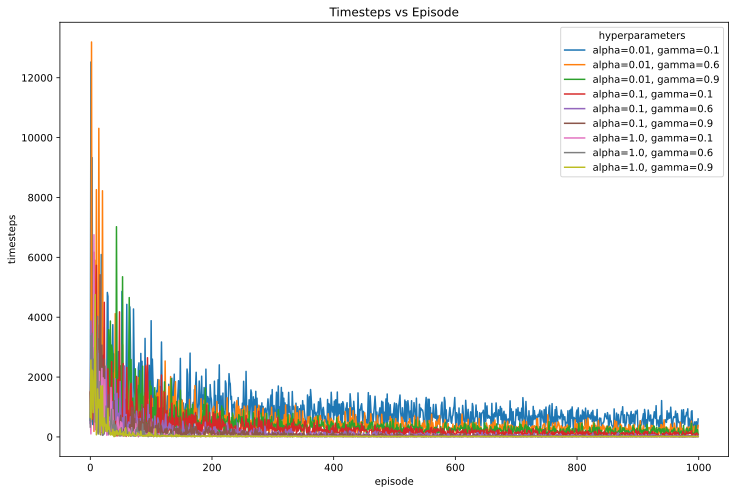

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


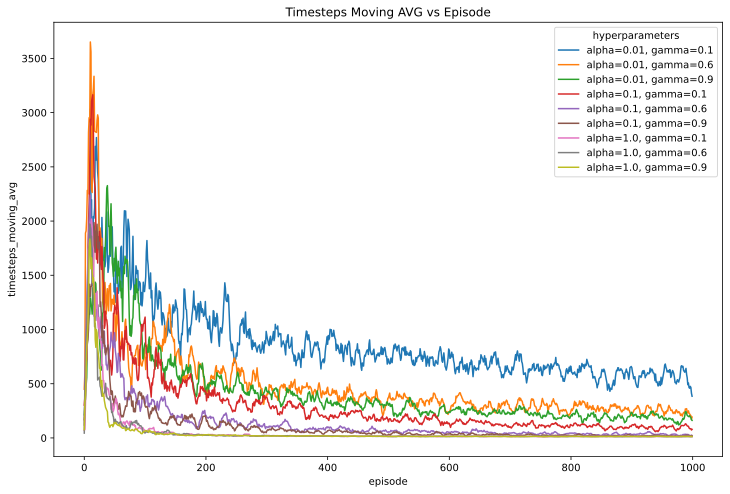

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'timesteps',
             hue='hyperparameters', data=results).set(title="Timesteps vs Episode")
plt.show()

results['timesteps_moving_avg'] = results['timesteps'].rolling(10).mean()

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'timesteps_moving_avg',
             hue='hyperparameters', data=results).set(title="Timesteps Moving AVG vs Episode")
plt.show()

#### Rewards

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


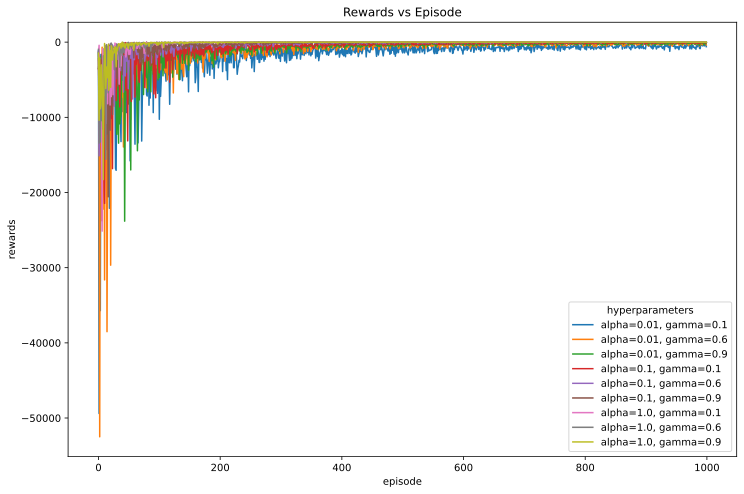

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


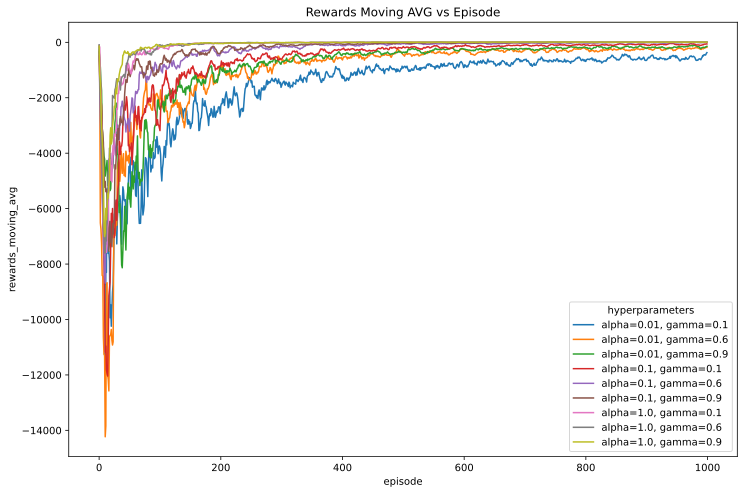

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'rewards',
             hue='hyperparameters', data=results).set(title="Rewards vs Episode")
plt.show()

results['rewards_moving_avg'] = results['rewards'].rolling(10).mean()

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'rewards_moving_avg',
             hue='hyperparameters', data=results).set(title="Rewards Moving AVG vs Episode")
plt.show()

alpha: 0.01, gamma: 0.1


100%|██████████| 1000/1000 [00:41<00:00, 24.33it/s]


alpha: 0.01, gamma: 0.9


100%|██████████| 1000/1000 [00:22<00:00, 44.80it/s]


alpha: 1, gamma: 0.1


100%|██████████| 1000/1000 [00:03<00:00, 287.69it/s]


alpha: 1, gamma: 0.9


100%|██████████| 1000/1000 [00:02<00:00, 419.40it/s]
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


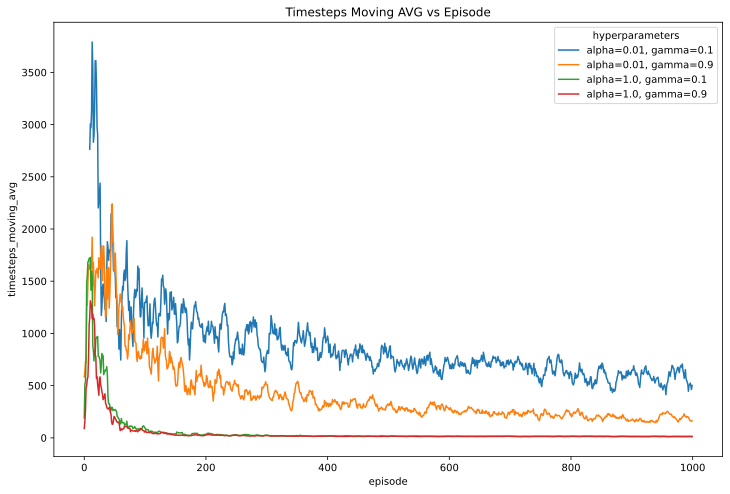

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


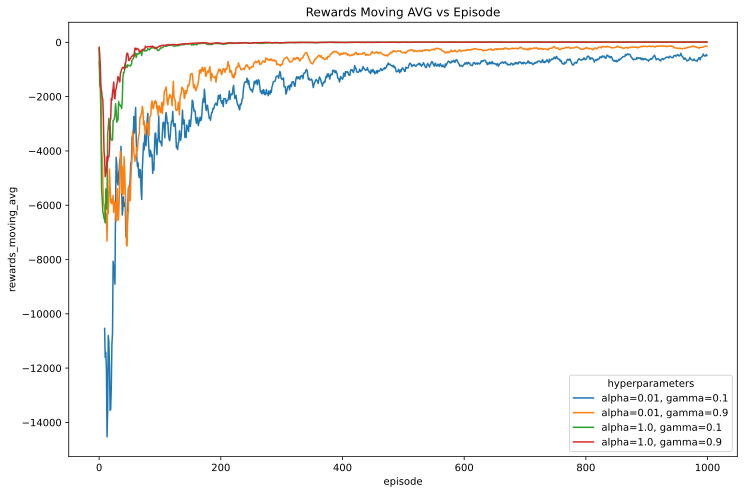

In [ ]:
# hyper-parameters
alphas = [0.01, 1]
gammas = [0.1, 0.9]

import pandas as pd

# exploration vs exploitation prob
# let's start with a constant probability of 10%.
epsilon = 0.1
n_episodes = 1000

results = pd.DataFrame()
for alpha in alphas:
    for gamma in gammas:
        
        print(f'alpha: {alpha}, gamma: {gamma}')
        agent = QAgent(env, alpha, gamma)
        
        _, timesteps, penalties, rewards = train(agent,
                                        env,
                                        n_episodes,
                                        epsilon)
        
        # collect timesteps and penalties for this pair
        # of hyper-parameters (alpha, gamma)
        results_ = pd.DataFrame()
        results_['timesteps'] = timesteps
        results_['penalties'] = penalties
        results_['rewards'] = rewards
        results_['alpha'] = alpha
        results_['gamma'] = gamma
        results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(
    columns={'index': 'episode'})

# add column with the 2 hyper-parameters
results['hyperparameters'] = [
    f'alpha={a}, gamma={g}'
    for (a, g) in zip(results['alpha'], results['gamma'])
]

import seaborn as sns
import matplotlib.pyplot as plt

results['timesteps_moving_avg'] = results['timesteps'].rolling(10).mean()

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'timesteps_moving_avg',
             hue='hyperparameters', data=results).set(title="Timesteps Moving AVG vs Episode")
plt.show()

results['rewards_moving_avg'] = results['rewards'].rolling(10).mean()

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'rewards_moving_avg',
             hue='hyperparameters', data=results).set(title="Rewards Moving AVG vs Episode")
plt.show()

### Epsilon

In [ ]:
# best hyper-parameters so far
alpha = 1.0
gamma = 0.9

epsilons = [0.01, 0.10, 0.9]
n_runs = 10
n_episodes = 200

results = pd.DataFrame()
for epsilon in epsilons:
        
    print(f'epsilon: {epsilon}')
    agent = QAgent(env, alpha, gamma)

    _, timesteps, penalties, rewards = train(agent,
                                env,
                                n_episodes,
                                epsilon)

    # collect timesteps and penalties for this pair of
    # hyper-parameters (alpha, gamma)
    results_ = pd.DataFrame()
    results_['timesteps'] = timesteps
    results_['penalties'] = penalties
    results_['rewards'] = rewards
    results_['epsilon'] = epsilon
    results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(columns={'index': 'episode'})

epsilon: 0.01


100%|██████████| 200/200 [00:02<00:00, 86.85it/s] 


epsilon: 0.1


100%|██████████| 200/200 [00:02<00:00, 87.11it/s] 


epsilon: 0.9


100%|██████████| 200/200 [00:03<00:00, 50.46it/s] 


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


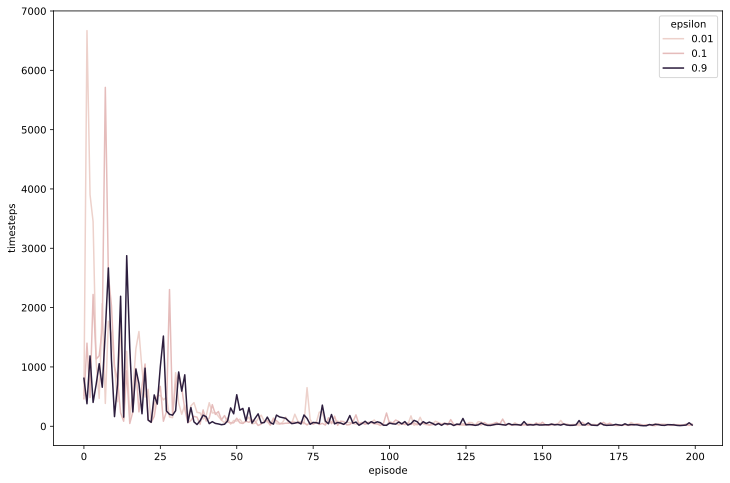

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


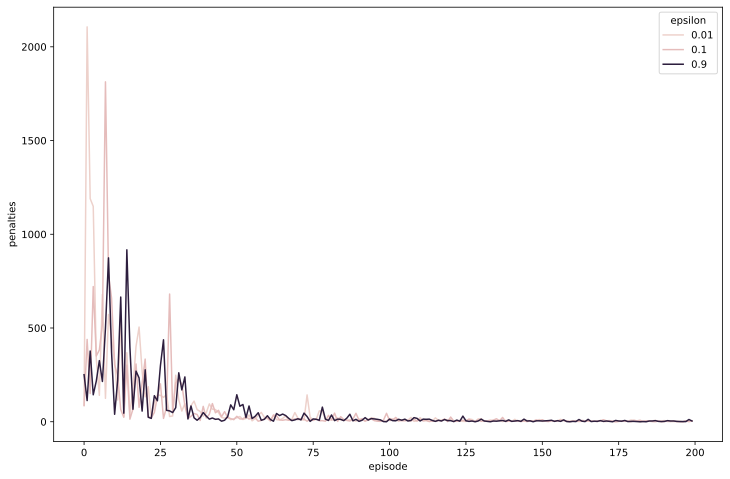

In [ ]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'timesteps', hue='epsilon', data=results)
plt.show()

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'penalties', hue='epsilon', data=results)
plt.show()